<a href="https://colab.research.google.com/github/filipes1lva/scripts_tcc_python/blob/main/ann_model_tcond_rku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
35# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Caminho do próprio drive ou local onde a base de dados está salva

In [ ]:
# Universidade Federal do Amazonas
# Faculdade de Tecnologia
# Departamento de Engenharia Mecânica
# Filipe Silva dos Santos - 21554004
%cd /content/drive/MyDrive/BD_TCC/

In [ ]:
!pip install tensorflow
!pip install pandas
!pip install seaborn
!pip install numpy
!pip install sklearn
!pip install hyperopt
!pip install matplotlib
!pip install ann_visualizer
!pip install keras

In [ ]:
# Importando bibliotecas necessárias

from skimage import data, io   # Import skimage library (data - Test images and example data.
#                          io - Reading, saving, and displaying images.)
from skimage.color import rgb2gray                  # Import matplotlib.pyplot (Plotting framework in Python.)
%matplotlib inline
import os                                        # This module provides a portable way of using operating system dependent functionality.'
import warnings
# Suppress warnings
warnings.filterwarnings('ignore')
from IPython.display import display
import cv2 as cv
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split 





#1 - Carregar base de Dados e armazenar o DataFrame 1, criar uma cópia para não afetar
#    a base de dados original e Remover Features que não serão utilizadas.

data = pd.read_csv("Exp2.csv")
data_prep1 = data.copy()

data_prep1.drop(['Run_ID', 'Experiment', 'Replica', 'Tool_ID', 'Group', 'Subgroup',
           'Position', 'Condition',
           'Machined_length', 'Init_diameter', 'Final_diameter', 'CTime', 'R_measurement'],
          axis=1, inplace=True)

data_prep1.tail()

In [ ]:
import seaborn as sns
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

plt.figure(figsize=(16,14))

sns.heatmap(data_prep1.astype('float32').corr(), linewidths=0.1, vmax=1.0, square=True, annot=True)

## Separação de dados em treino, teste e validação

A função recebe três argumentos:

- data: que é o conjunto de dados a ser usado para a análise;
- target: que é a variável alvo da análise;
- task: que é a tarefa a ser realizada (por padrão, é "regression").
A função primeiro cria uma cópia do conjunto de dados e armazena a variável alvo em uma nova variável. Em seguida, ela adiciona uma nova coluna chamada "Set" com valores aleatórios ("train", "valid" e "test") para cada linha do conjunto de dados.

Depois, a função identifica as colunas categóricas no conjunto de dados, converte seus valores para números usando a função LabelEncoder() e armazena o número de categorias em cada coluna categórica na variável "categorical_dims". Para as colunas numéricas, a função preenche os valores nulos com a média dos valores da coluna.

A função cria ainda uma lista de recursos, que é composta por todas as colunas no conjunto de dados que não são a variável alvo ou a coluna "Set". Ela também identifica os índices e dimensões das colunas categóricas.

Finalmente, a função divide o conjunto de dados em três conjuntos (treinamento, validação e teste) com base nos valores aleatórios da coluna "Set" criada anteriormente. Ela retorna os conjuntos de recursos e variáveis alvo para cada um dos três conjuntos.

In [ ]:
def setup_reg(data,target, task='regression'):
    train = data.copy()
    target = target
    if "Set" not in train.columns:
        train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

    train_indices = train[train.Set=="train"].index
    valid_indices = train[train.Set=="valid"].index
    test_indices = train[train.Set=="test"].index

    categorical_columns = []
    categorical_dims =  {}
    for col in train.columns[train.dtypes == object]:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)

    for col in train.columns[train.dtypes == 'float64']:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

    unused_feat = ['Set']

    features = [ col for col in train.columns if col not in unused_feat+[target]] 

    cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

    cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

    

    X_train = train[features].values[train_indices]
    y_train = train[target].values[train_indices].reshape(-1, 1)

    X_valid = train[features].values[valid_indices]
    y_valid = train[target].values[valid_indices].reshape(-1, 1)

    X_test = train[features].values[test_indices]
    y_test = train[target].values[test_indices].reshape(-1, 1)

    return X_train, y_train, X_valid,y_valid, X_test, y_test

In [ ]:
#5 -Criação do Modelo

def create_model(args):
    model = keras.Sequential()
    model.add(layers.Dense(64, input_dim=8,activation=args['activation']))
    model.add(layers.Dense(64, activation=args['activation']))
    if args['extra_layer']:
      model.add(layers.Dense(64, activation=args['activation']))
    model.add(layers.Dense(args['neurons'], args['activation']))
    if args['drop1']:
      model.add(layers.Dropout(0.09))
    model.add(layers.Dense(1))
    
    model.compile(loss="mean_squared_error",
                      optimizer=args['optimizer'],
                      metrics=["mean_absolute_percentage_error",
                      "mean_absolute_error"])
    return model


early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001, # mínima quantidade para se considerar como melhoria
    patience=600, # Quantas epochs esperar antes de parar
    restore_best_weights=True,
)
    

## Etapa de otimização das variaveis
- Algoritmo utilizado: Hyperopt

O código define uma variável chamada "space" que contém um dicionário com seis hiperparâmetros para serem ajustados durante a busca de hiperparâmetros.

Os seis hiperparâmetros e seus possíveis valores são:

- "drop1": um hiperparâmetro booleano que controla se uma camada de dropout deve ser adicionada à rede neural (escolha entre True e False);
- "scale_dataset": um hiperparâmetro booleano que controla se o conjunto de dados deve ser escalado (escolha entre True e False);
- "extra_layer": um hiperparâmetro booleano que controla se uma camada extra deve ser adicionada à rede neural (escolha entre True e False);
- "neurons": um hiperparâmetro discreto que controla o número de neurônios na última camada da rede neural (escolha entre 64, 32 e 16);
- "activation": um hiperparâmetro discreto que controla a função de ativação a ser usada nas camadas da rede neural (escolha entre "relu", "sigmoid" e "tanh");
- "optimizer": um hiperparâmetro discreto que controla o otimizador a ser usado na rede neural (escolha entre "sgd", "adam" e "rmsprop").

Esses hiperparâmetros serão usados em conjunto com uma função de avaliação do modelo para encontrar a combinação ideal de hiperparâmetros que resulte no melhor desempenho do modelo.

In [ ]:
from hyperopt import hp
space ={ 
    'drop1' : hp.choice('drop_1',[True,False]),
    'scale_dataset':hp.choice("scale",[True,False]),
    'extra_layer':hp.choice("extra_layer",[True,False]),
    'neurons':hp.choice("neurons_last_layer",[64,32,16]),
    'activation':hp.choice("activation_function",['relu','sigmoid','tanh']),
    'optimizer': hp.choice("optimizer_function",['sgd','adam','rmsprop'])
    }

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

config_list=[]
report_list=[]
auc_list=[]
import keras.backend as K
def optimized_preprocessing(space=None):
  print(space)
  print("Carregando os dados")
  data = data_prep1.drop(["Ra", "Rz", "Rsk", "RSm", "Rt"], axis=1)
  target = "Rku"

  X_train, y_train, X_valid,y_valid, X_test, y_test = setup_reg(data,target,task='regression')
  if space['scale_dataset']:
    from sklearn.preprocessing import MinMaxScaler
    scaler =  MinMaxScaler()
    X_train=scaler.fit_transform(X_train)
    X_valid=scaler.fit_transform(X_valid)
    X_test=scaler.fit_transform(X_test)

  
  K.clear_session()
  model = create_model(space)
  model.summary()

  history = model.fit(
      X_train, y_train,
      validation_data=(X_valid, y_valid),
      batch_size=16,
      epochs=10000,
      callbacks=[early_stopping], # Põe os callbacks na lista
      verbose=0,  
  )

  from sklearn.metrics import r2_score

  x_pred = model.predict(X_test)

  r2 = r2_score(y_test, x_pred)

  print('O valor de r² é:', r2)

  config_list.append(space)
  auc_list.append(r2)
  


  sub_dict = {'Config': [],'r2':[]}
  sub_dict['Config'] =config_list
  sub_dict['r2'] = auc_list

  log = pd.DataFrame(sub_dict)

  log.to_csv('log_treino.csv', index=False)
  return {
      'loss':1-r2,
      'status': STATUS_OK,
  }



O código abaixo utiliza o módulo "hyperopt" para realizar uma busca pelos melhores hiperparâmetros para um modelo de aprendizado de máquina.

- O código cria um objeto "Trials()" para armazenar informações sobre as tentativas de treinamento de modelo realizadas durante a busca pelos hiperparâmetros ideais.

- Em seguida, o código define uma variável "space" que contém o espaço de hiperparâmetros a serem otimizados pelo algoritmo.

- Depois, o código chama a função "fmin" do módulo "hyperopt", que recebe três argumentos:

  - A função de otimização que será usada para avaliar os modelos com diferentes combinações de hiperparâmetros (no exemplo, essa função é chamada de "optimized_preprocessing");
  - O espaço de hiperparâmetros a serem otimizados (no exemplo, essa variável é chamada de "space");
  
O algoritmo de busca por hiperparâmetros que será usado para explorar o espaço de hiperparâmetros (no exemplo, o algoritmo é o "tpe.suggest", que é um algoritmo baseado em árvores de probabilidade).
Além disso, o código também especifica um limite máximo de avaliações que serão realizadas (30 no exemplo) e a variável "trials" que armazenará informações sobre as tentativas de treinamento realizadas durante a busca. O resultado final da função "fmin" será o conjunto de hiperparâmetros que resultou no melhor desempenho de acordo com a função de avaliação especificada.

In [ ]:

from sklearn.preprocessing import LabelEncoder

trials = Trials()
space = space
best = fmin(optimized_preprocessing,
    space=space,
    algo=tpe.suggest,
    max_evals=30,
    trials=trials)


{'activation': 'relu', 'drop1': False, 'extra_layer': True, 'neurons': 32, 'optimizer': 'adam', 'scale_dataset': False}
Carregando os dados
Set
3
Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 dense (Dense)               (None, 64)                576       

 dense_1 (Dense)             (None, 64)                4160      

 dense_2 (Dense)             (None, 64)                4160      

 dense_3 (Dense)             (None, 32)                2080      

 dense_4 (Dense)             (None, 1)                 33        


Total params: 11,009

Trainable params: 11,009

Non-trainable params: 0

_________________________________________________________________

1/1 [==============================] - 0s 103ms/step

O valor de r² é:
0.838163686749064
{'activation': 'relu', 'drop1': True, 'extra_layer': True, 'neurons': 16, 'optimizer': 'adam', 'scale_dataset': False}
Carregando os 

2/2 [==============================] - 0s 14ms/step

O valor de r² é:
0.5038414386944363
{'activation': 'relu', 'drop1': False, 'extra_layer': False, 'neurons': 16, 'optimizer': 'sgd', 'scale_dataset': True}
Carregando os dados
Set
3
Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 dense (Dense)               (None, 64)                576       

 dense_1 (Dense)             (None, 64)                4160      

 dense_2 (Dense)             (None, 16)                1040      

 dense_3 (Dense)             (None, 1)                 17        


Total params: 5,793

Trainable params: 5,793

Non-trainable params: 0

_________________________________________________________________

 17%|█▋        | 5/30 [21:03<1:36:19, 231.18s/trial, best loss: 0.11681359675994807]

1/1 [==============================] - 0s 81ms/step

O valor de r² é:
0.4198357205628577
{'activation': 'tanh', 'drop1': False, 'extra_layer': False, 'neurons': 64, 'optimizer': 'adam', 'scale_dataset': True}
Carregando os dados
Set
3
Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 dense (Dense)               (None, 64)                576       

 dense_1 (Dense)             (None, 64)                4160      

 dense_2 (Dense)             (None, 64)                4160      

 dense_3 (Dense)             (None, 1)                 65        


Total params: 8,961

Trainable params: 8,961

Non-trainable params: 0

_________________________________________________________________

2/2 [==============================] - 0s 11ms/step

O valor de r² é:
0.7845429910790468
{'activation': 'sigmoid', 'drop1': False, 'extra_layer': False, 'neurons': 16, 'optimizer': 'sgd', 'scale_dataset

In [ ]:
print(best)

## Script Principal
- O modelo abaixo é um modelo candidato que consegue alcançar um R2 acima de 0.9
- A seed para replicar esse treino é a 884734 (é o valor que vai na variável random state)

In [ ]:
def create_model():
    model = keras.Sequential()
    model.add(layers.Dense(64, input_dim=8,activation= 'relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(64, 'relu'))
    model.add(layers.Dense(16, 'relu'))
    model.add(layers.Dense(1))
    
    model.compile(loss="mean_squared_error",
                      optimizer='rmsprop',
                      metrics=["mean_absolute_percentage_error",
                      "mean_absolute_error"])
    return model


early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001, # mínima quantidade para se considerar como melhoria
    patience=600, # Quantas epochs esperar antes de parar
    restore_best_weights=True,
)

In [ ]:
from sklearn.metrics import r2_score
import keras.backend as K

data = data_prep1.drop(["Ra", "Rz", "Rsk", "RSm", "Rt"], axis=1)
target = "Rku"
K.clear_session()

sep = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=884734)

for train_index, test_index in sep.split(data_prep1, data_prep1["f"]):
    stratified_train_set = data_prep1.loc[train_index]
    stratified_test_set = data_prep1.loc[test_index]
    
df_train = pd.DataFrame(stratified_train_set)
df_test = pd.DataFrame(stratified_test_set)



X_train_and_valid = df_train.drop(["Ra", "Rz", "Rsk", "Rku", "RSm", "Rt"], axis=1)  
X_test = df_test.drop(["Ra", "Rz", "Rsk", "Rku", "RSm", "Rt"], axis=1)

#3.2 - Variáveis de Saída - Kurtose
y_train = df_train[["Rku"]]  
y_test = df_test[["Rku"]] 

X_train, X_valid,\
y_train, y_valid = train_test_split(X_train_and_valid,y_train,
                                test_size=0.20, random_state=884734)



model = create_model()
model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=16,
    epochs=10000,
    callbacks=[early_stopping], # Põe os callbacks na lista
    verbose=0,  
)
x_pred = model.predict(X_test)

r2 = r2_score(y_test, x_pred)
print('O valor de r² é:', r2)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                576       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 16)                1040      
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 9,953
Trainable params: 9,953
Non-trainable params: 0
_________________________________________________________________
2/2 [==============================] - 0s 3ms/step
O v

In [ ]:
loss = model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 9ms/step - loss: 0.0281 - mean_absolute_percentage_error: 5.4106 - mean_absolute_error: 0.1277


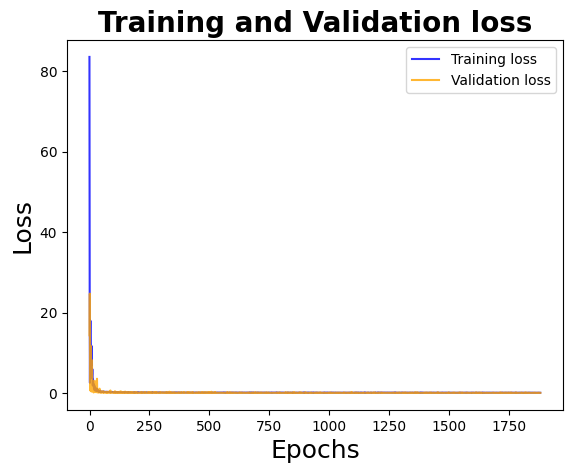

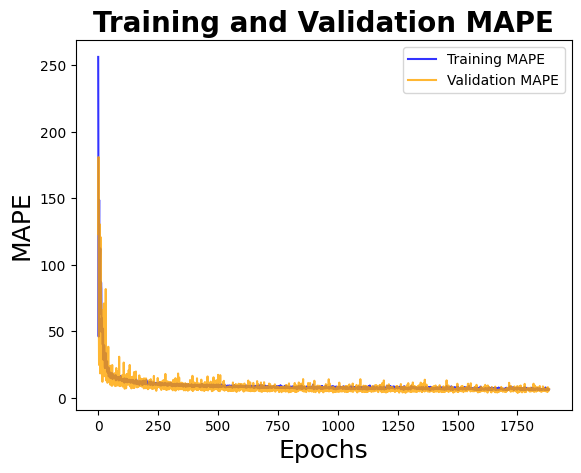

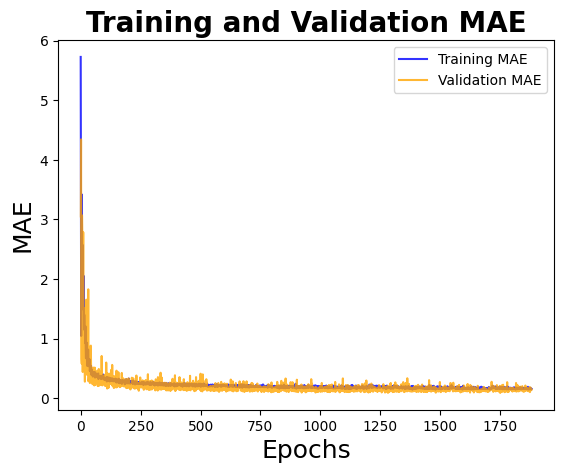

In [ ]:
# Visualização das curvas de aprendizado

color = ['black', 'dgray', 'gray', 'dblue', 'blue', 'lblue', 'red', 'orange']

epochs = np.arange(0, len(history.history['loss']))

train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs - 0.5, train_loss, color=color[4], alpha=0.8, label='Training loss')
plt.plot(epochs, val_loss, color=color[7], alpha=0.8, label='Validation loss')
plt.title('Training and Validation loss', size=20, fontweight='bold')
plt.xlabel('Epochs', size=18)
plt.ylabel('Loss', size=18)
plt.legend()
plt.show()

train_mape = history.history['mean_absolute_percentage_error']
val_mape = history.history['val_mean_absolute_percentage_error']
plt.plot(epochs - 0.5, train_mape, color=color[4], alpha=0.8, label='Training MAPE')
plt.plot(epochs, val_mape, color=color[7], alpha=0.8, label='Validation MAPE')
plt.title('Training and Validation MAPE', size=20, fontweight='bold')
plt.xlabel('Epochs', size=18)
plt.ylabel('MAPE', size=18)
plt.legend()
plt.show()

train_mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']
plt.plot(epochs - 0.5, train_mae, color=color[4], alpha=0.8, label='Training MAE')
plt.plot(epochs, val_mae, color=color[7], alpha=0.8, label='Validation MAE')
plt.title('Training and Validation MAE', size=20, fontweight='bold')
plt.xlabel('Epochs', size=18)
plt.ylabel('MAE', size=18)
plt.legend()
plt.show()

2/2 [==============================] - 0s 5ms/step


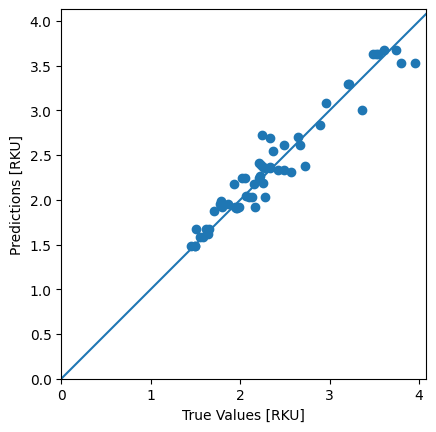

In [ ]:
test_predictions = model.predict(X_test).flatten()
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [RKU]')
plt.ylabel('Predictions [RKU]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])



In [ ]:
from sklearn.metrics import r2_score

x_pred = model.predict(X_test)

r2 = r2_score(y_test, x_pred)

print('O valor de r² é:', r2)

2/2 [==============================] - 0s 5ms/step
O valor de r² é: 0.9334060350985613


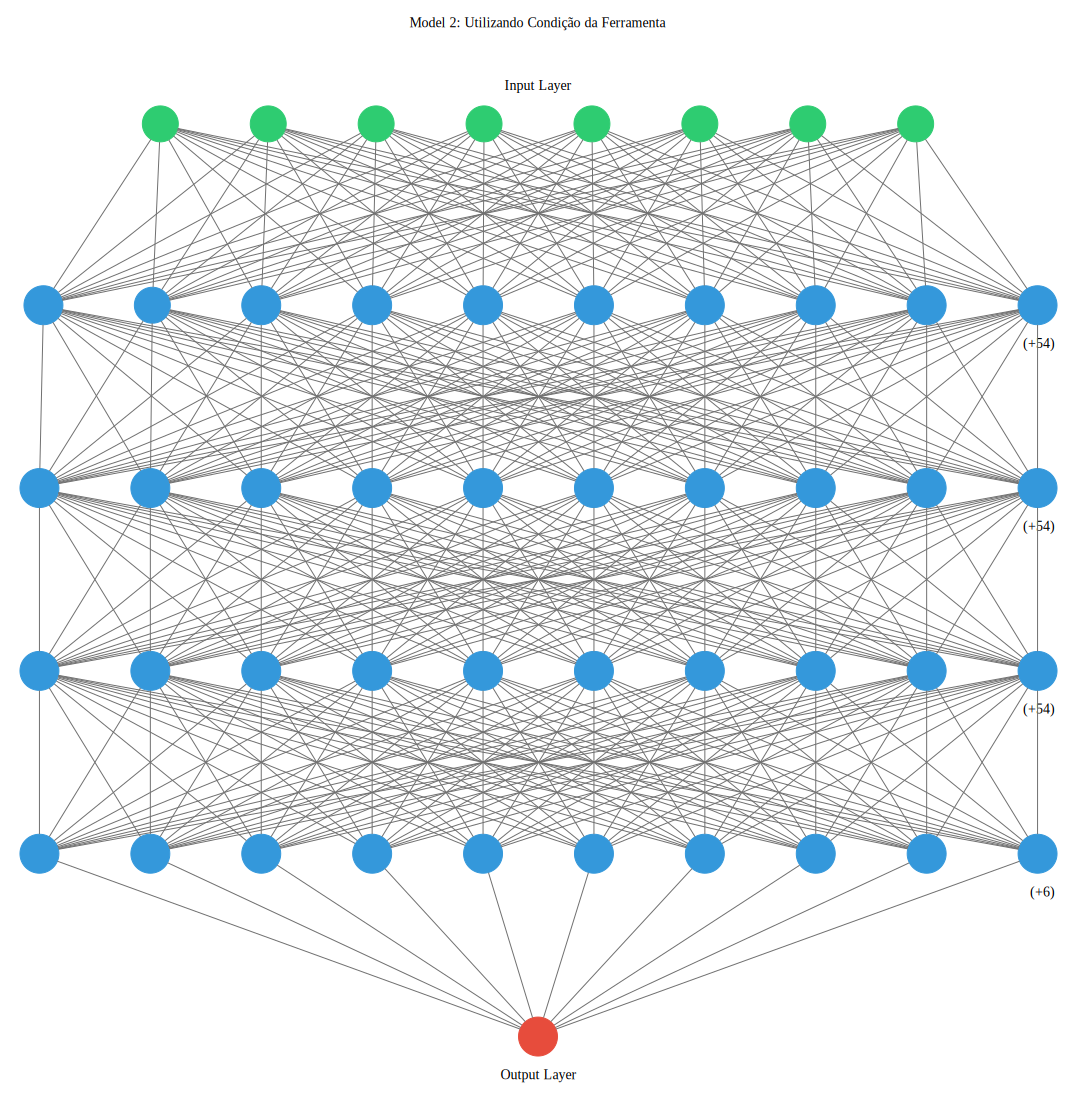

In [ ]:
from ann_visualizer.visualize import ann_viz
from graphviz import Source

ann_viz(model, filename= "network.gv", title="Model 2: Utilizando Condição da Ferramenta")
Source.from_file('./network.gv')